<style>
    table {
        border-collapse: collapse;
        width: 50%;
        border-radius: 10px; /* Adjust the radius as needed */
        overflow: hidden;
        margin: auto; /* Center the table within its container */
    }

    table, th, td {
        border: 3px solid black;
    }

    th, td {
        padding: 10px;
        text-align: center;
    }
</style>

<div style="text-align:center">
        <img src="mage.png">
        <h1>WIZARD OF WIKIPEDIA</h1>
        <h2>Knowledge-powered Conversational Agents</h2>
</div>
<table>
    <tr>
        <td>Eleonora BARDELLI</td>
        <td>Isin Su ECEVIT</td>
    </tr>
    <tr>
        <td>Vedang NAIK</td>
        <td>Kaan Egemen SEN</td>
    </tr>
</table>



In this work we observe and test models on the [ Wizard of Wikipedia](https://arxiv.org/abs/1811.01241) dataset. In the following sections, we first analyze the data, then compare our models, and finally we add voice interaction to the best performing model.

# Setup

## Installations

In [2]:
!pip install  parlai
!pip install  subword_nmt # extra requirement we need for this tutorial
!pip install --upgrade huggingface-hub transformers

  Using cached attrs-20.2.0-py2.py3-none-any.whl (48 kB)
  Using cached numpy-1.23.5-cp310-cp310-macosx_11_0_arm64.whl (13.4 MB)
  Using cached fsspec-2022.2.0-py3-none-any.whl (134 kB)
INFO: pip is looking at multiple versions of huggingface-hub to determine which version is compatible with other requirements. This could take a while.
  Using cached huggingface_hub-0.20.1-py3-none-any.whl.metadata (12 kB)
  Using cached huggingface_hub-0.20.0-py3-none-any.whl.metadata (12 kB)
  Using cached huggingface_hub-0.19.4-py3-none-any.whl.metadata (14 kB)
  Using cached huggingface_hub-0.19.3-py3-none-any.whl.metadata (14 kB)
  Using cached huggingface_hub-0.19.2-py3-none-any.whl.metadata (13 kB)
  Using cached huggingface_hub-0.19.1-py3-none-any.whl.metadata (13 kB)
  Using cached huggingface_hub-0.19.0-py3-none-any.whl.metadata (13 kB)
INFO: pip is still looking at multiple versions of huggingface-hub to determine which version is compatible with other requirements. This could take a while.


In [3]:
!pip install -U openai-whisper
!pip install numpy scipy librosa unidecode inflect

In [4]:
!brew install ffmpeg
!pip install gTTS
!pip install playsound
!pip install pygame

Running `brew update --auto-update`...
==> Auto-updated Homebrew!
Updated 3 taps (shivammathur/php, homebrew/core and homebrew/cask).
==> New Formulae
zigmod
==> New Casks
shadow-bot

You have 10 outdated formulae installed.

To reinstall 6.1.1_2, run:
  brew reinstall ffmpeg


In [5]:
!pip install torch torchvision
!pip install matplotlib
!pip install plotly
!pip install wordcloud
!pip install --upgrade nbformat
!pip install --upgrade numpy

  Using cached attrs-23.2.0-py3-none-any.whl.metadata (9.5 kB)
Using cached attrs-23.2.0-py3-none-any.whl (60 kB)
  Attempting uninstall: attrs
    Found existing installation: attrs 20.2.0
    Uninstalling attrs-20.2.0:
      Successfully uninstalled attrs-20.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
parlai 1.7.2 requires attrs~=20.2.0, but you have attrs 23.2.0 which is incompatible.
parlai 1.7.2 requires fsspec~=2022.2.0, but you have fsspec 2023.12.2 which is incompatible.
  Using cached numpy-1.26.3-cp310-cp310-macosx_11_0_arm64.whl.metadata (61 kB)
Using cached numpy-1.26.3-cp310-cp310-macosx_11_0_arm64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the pac

## Imports

In [6]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/usi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/usi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Style

In [9]:
red='#863541'
orange='#ECA87F'
green='#7BBDAA'

# Investigate Dataset

The dataset consists of dialogues between two participants: a knowledgeable expert (wizard) and a curious learner (apprentice). Topics for the conversations are taken from Wikipedia articles.

In [10]:
df0=pd.read_json('data.json')

In [14]:
num_documents = len(df0)
print(f"Number of documents: {num_documents}")
print('\nExample of a dialog:')
print(df0['dialog'][0])

Number of documents: 22311

Example of a dialog:
[{'speaker': '0_Wizard', 'text': "I think science fiction is an amazing genre for anything. Future science, technology, time travel, FTL travel, they're all such interesting concepts.", 'checked_sentence': {'chosen_Science_fiction_0': 'Science fiction (often shortened to SF or sci-fi) is a genre of speculative fiction, typically dealing with imaginative concepts such as futuristic science and technology, space travel, time travel, faster than light travel, parallel universes, and extraterrestrial life.'}, 'checked_passage': {'chosen_topic_0_Science_fiction': 'Science fiction'}, 'retrieved_passages': [{'Hyperspace (science fiction)': ['Hyperspace is a faster-than-light (FTL) method of traveling used in science fiction.', 'It is typically described as an alternative "sub-region" of space co-existing with our own universe which may be entered using an energy field or other device.', 'As seen in most fiction hyperspace is most succinctly des

The final dialogue dataset consists of 22,311 dialogues with a total of 201,999 turns.

## Distribution Plots over Document Length and Vocabulary Size

In [11]:
# Calculate document length and vocabulary size
df0['document_length'] = df0['dialog'].apply(lambda x: len(x[0]['text'].split()))
df0['vocabulary_size'] = df0['dialog'].apply(lambda x: len(set(x[0]['text'].split())))

# Visualize distribution over document length
fig_document_length = px.histogram(df0, x='document_length', nbins=50, title='Distribution over Document Length')
fig_document_length.update_layout(xaxis_title='Document Length', yaxis_title='Frequency', bargap=0.2, width=800)
fig_document_length.update_traces(marker_color=red)

# Visualize distribution over vocabulary size with green color
fig_vocabulary_size = px.histogram(df0, x='vocabulary_size', nbins=50, title='Distribution over Vocabulary Size')
fig_vocabulary_size.update_layout(xaxis_title='Vocabulary Size', yaxis_title='Frequency', bargap=0.2, width=800)
fig_vocabulary_size.update_traces(marker_color=green)

fig_document_length.show()
fig_vocabulary_size.show()

## Keyword Search

In [12]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(df0['dialog'].apply(lambda x: x[0]['text']))

def keyword_search(query, tfidf_matrix, tfidf_vectorizer, num_results=5):
    query_vector = tfidf_vectorizer.transform([query])
    cosine_similarities = linear_kernel(query_vector, tfidf_matrix).flatten()
    related_documents_indices = cosine_similarities.argsort()[:-num_results-1:-1]
    return df0.iloc[related_documents_indices]

query = "machine learning"
search_results = keyword_search(query, tfidf_matrix, tfidf_vectorizer)
print(f"Keyword search results for '{query}':")

for i, row in search_results.iterrows():
    print(f"Document Index: {i}")
    print(f"Document Text: {row['dialog'][0]['text']}")
    print('-' * 50)

Keyword search results for 'machine learning':
Document Index: 1752
Document Text: Have you used a sewing machine before?
--------------------------------------------------
Document Index: 8603
Document Text: Do you have any idea how to use a sewing machine?
--------------------------------------------------
Document Index: 20749
Document Text: I'm learning how to play the piano.
--------------------------------------------------
Document Index: 16644
Document Text: i am interesting in learning how to draw
--------------------------------------------------
Document Index: 6973
Document Text: I love sewing. I got my first sewing machine when I was 13.
--------------------------------------------------


We can see that the keyword search for 'machine learning' yields responses that are related to sewing and learning, indicating that the dataset might be biased towards non-technical topics.

## Word2Vec


In [13]:
tokenized_text = df0['dialog'].apply(lambda x: word_tokenize(x[0]['text'].lower()))

model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

print("Similarity between 'machine' and 'learning':", model.wv.similarity('machine', 'learning'))
print("Most similar words to 'machine':", model.wv.most_similar('machine'))
print("Most similar words to 'learning':", model.wv.most_similar('learning'))

Similarity between 'machine' and 'learning': 0.71028817
Most similar words to 'machine': [('narcissus', 0.9727839231491089), ('individual', 0.9663203954696655), ('corvette', 0.9657765030860901), ('rate', 0.965203583240509), ('flight', 0.9645726680755615), ('gas', 0.9644388556480408), ('taxi', 0.9631717801094055), ('coming', 0.9628368616104126), ('stores', 0.9628146290779114), ('stock', 0.9626534581184387)]
Most similar words to 'learning': [('lately', 0.9355200529098511), ('freckles', 0.9339648485183716), ('vegetarianism', 0.9302944540977478), ('yoga', 0.9259385466575623), ('something', 0.9234920144081116), ('joining', 0.9218471646308899), ('conscious', 0.918479859828949), ('parachuting', 0.917523980140686), ('surfing', 0.9173936247825623), ('research', 0.9126752614974976)]


As mentioned previously, the similarity between the words 'machine' and learning, although being somewhat high, is not as significant as words from other domains in the dataset.

## t-SNE Plot

In [14]:
vocab = list(model.wv.index_to_key)
vectors = np.array([model.wv[word] for word in vocab])

tsne_model = TSNE(n_components=2, random_state=42)
tsne_vectors = tsne_model.fit_transform(vectors)

tsne_df = pd.DataFrame(tsne_vectors, columns=['X', 'Y'])
tsne_df['Word'] = vocab

fig_tsne = px.scatter(tsne_df, x='X', y='Y', text='Word', title='t-SNE Plot')
fig_tsne.update_traces(marker=dict(size=8),marker_color=orange)

fig_tsne.show()

In [15]:
top_words = model.wv.index_to_key[:500]

top_vectors = np.array([model.wv[word] for word in top_words])

tsne_model = TSNE(n_components=2, random_state=42)
tsne_vectors = tsne_model.fit_transform(top_vectors)

tsne_df = pd.DataFrame(tsne_vectors, columns=['X', 'Y'])
tsne_df['Word'] = top_words

fig_tsne_top_words = px.scatter(tsne_df, x='X', y='Y', text='Word', title='t-SNE Plot for Top 500 Words')
fig_tsne_top_words.update_traces(marker=dict(size=8),marker_color=orange)

fig_tsne_top_words.show()

The scattered t-SNE plot indicates that the dataset lacks clear clusters or separable patterns in its lower-dimensional representation. 

This is expected since the dataset is supposed to contribute to the training of conversational models that are informed about a large number of different topics in order to carry the conversation accurately.

In [16]:
columns = ['question', 'answer', 'topic']
df = pd.DataFrame(columns=columns)

for i in range(len(df0['dialog'])):
    el = df0['dialog'].values[i][0]

    retrieved_passages = df0.at[i, 'dialog'][0]['retrieved_passages']

    answers = [''.join([''.join(string) for a in elem.values() for string in a]) for elem in retrieved_passages]
    topics = el.get('retrieved_topics', 'unclassified')

    df = pd.concat([df, pd.DataFrame({'question': [el['text']] * len(answers),
                                        'answer': answers,
                                        'topic': [topics] * len(answers)})], ignore_index=True)

In [17]:
print(df.head())

                                            question  \
0  I think science fiction is an amazing genre fo...   
1  I think science fiction is an amazing genre fo...   
2  I think science fiction is an amazing genre fo...   
3  I think science fiction is an amazing genre fo...   
4  I think science fiction is an amazing genre fo...   

                                              answer  \
0  Hyperspace is a faster-than-light (FTL) method...   
1  Science fiction (often shortened to SF or sci-...   
2  The literary genre of science fiction is diver...   
3  Science fiction film (or sci-fi film) is a gen...   
4  Time travel is the concept of movement between...   

                                               topic  
0  [Hyperspace (science fiction), Science fiction...  
1  [Hyperspace (science fiction), Science fiction...  
2  [Hyperspace (science fiction), Science fiction...  
3  [Hyperspace (science fiction), Science fiction...  
4  [Hyperspace (science fiction), Science fiction..

In [18]:
question = df['question']
answer = df['answer']
topic = df['topic']

print(question[0:10], '\n', answer[0:10])

0    I think science fiction is an amazing genre fo...
1    I think science fiction is an amazing genre fo...
2    I think science fiction is an amazing genre fo...
3    I think science fiction is an amazing genre fo...
4    I think science fiction is an amazing genre fo...
5    I think science fiction is an amazing genre fo...
6    I think science fiction is an amazing genre fo...
7    Can you imagine the world without internet acc...
8    Can you imagine the world without internet acc...
9    Can you imagine the world without internet acc...
Name: question, dtype: object 
 0    Hyperspace is a faster-than-light (FTL) method...
1    Science fiction (often shortened to SF or sci-...
2    The literary genre of science fiction is diver...
3    Science fiction film (or sci-fi film) is a gen...
4    Time travel is the concept of movement between...
5    This is a list of fictional starships in the "...
6    Science fiction and fantasy magazines began to...
7    The right to Internet access

## Tokenization

In [19]:
def clear_punctuation(word):
    word = str(word).lower()
    word = re.sub(r'[^\w\s]', ' ', word)
    # Replace consecutive spaces with a single space
    word = re.sub(' +', ' ', word)
    return word.strip()

def tokenize(sentence):
    return [] if sentence is None else sentence.split()

question = [clear_punctuation(sentence) for sentence in question]
answer = [clear_punctuation(sentence) for sentence in answer]

questions = [tokenize(sentence.lower()) for sentence in question]
answers = [tokenize(sentence.lower()) for sentence in answer]
tokenized_sentences = list(zip(questions, answers))

for sentence in tokenized_sentences[:10]:
    print(sentence)

(['i', 'think', 'science', 'fiction', 'is', 'an', 'amazing', 'genre', 'for', 'anything', 'future', 'science', 'technology', 'time', 'travel', 'ftl', 'travel', 'they', 're', 'all', 'such', 'interesting', 'concepts'], ['hyperspace', 'is', 'a', 'faster', 'than', 'light', 'ftl', 'method', 'of', 'traveling', 'used', 'in', 'science', 'fiction', 'it', 'is', 'typically', 'described', 'as', 'an', 'alternative', 'sub', 'region', 'of', 'space', 'co', 'existing', 'with', 'our', 'own', 'universe', 'which', 'may', 'be', 'entered', 'using', 'an', 'energy', 'field', 'or', 'other', 'device', 'as', 'seen', 'in', 'most', 'fiction', 'hyperspace', 'is', 'most', 'succinctly', 'described', 'as', 'a', 'somewhere', 'else', 'within', 'which', 'the', 'laws', 'of', 'general', 'and', 'special', 'relativity', 'decidedly', 'do', 'not', 'apply', 'especially', 'with', 'respect', 'to', 'the', 'speed', 'of', 'light', 'being', 'the', 'cosmic', 'speed', 'limit', 'entering', 'and', 'exiting', 'said', 'elsewhere', 'thus', '

## Most Frequent 20 Topics

In [20]:
topic_list = [item for sublist in df['topic'].dropna() for item in sublist]

occurrences = Counter(topic_list).items()
sorted_data = sorted(occurrences, key=lambda x: x[1], reverse=True)

# Limit the number of topics to display
limit_topics = 20  
sorted_data_top_topics = sorted_data[:limit_topics]
x, y = zip(*sorted_data_top_topics)

fig = px.bar(x=y, y=x, labels={'x': 'Number of sentences per topic', 'y': 'Topic'},
             title='Top {} Most Frequent Topics'.format(limit_topics),
             text_auto=True, orientation='h')

fig.update_yaxes(categoryorder='total ascending')  
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False,marker_color=green)
fig.update_layout(height=800)  

fig.show()

## Further Statistics

In [21]:
question = df['question'].apply(clear_punctuation)
answer = df['answer'].apply(clear_punctuation)
 
questions = [tokenize(sentence.lower()) for sentence in question]
answers = [tokenize(sentence.lower()) for sentence in answer]

tokenized_sentences = [item for sublist in zip(questions, answers) for item in sublist]
word_occurrences = Counter([word for sublist in tokenized_sentences for word in sublist])
unique_words = list(word_occurrences.keys())
num_unique_words = len(unique_words)

#Statistics
max_occurrences = max(word_occurrences.values())
min_occurrences = min(word_occurrences.values())
average_occurrences = sum(word_occurrences.values()) / len(word_occurrences)
median_occurrences = statistics.median(word_occurrences.values())

print("Number of Unique Words:", num_unique_words)
print("Max Number of Occurrences:", max_occurrences)
print("Min Number of Occurrences:", min_occurrences)
print("Average Occurrences:", average_occurrences)
print("Median Occurrences:", median_occurrences)

Number of Unique Words: 137204
Max Number of Occurrences: 1233369
Min Number of Occurrences: 1
Average Occurrences: 147.58758491006094
Median Occurrences: 4.0


## Wordcloud

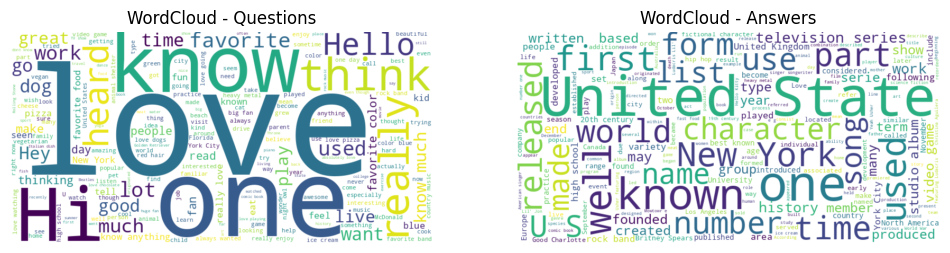

In [22]:
# Combine all questions and answers into a single string
all_questions = ' '.join(df['question'])
all_answers = ' '.join(df['answer'])

wordcloud_questions = WordCloud(width=800, height=400, background_color='white').generate(all_questions)
wordcloud_answers = WordCloud(width=800, height=400, background_color='white').generate(all_answers)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_questions, interpolation='bilinear')
plt.title('WordCloud - Questions')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_answers, interpolation='bilinear')
plt.title('WordCloud - Answers')
plt.axis('off')

plt.show()

## Most Frequent Words

In [23]:
flat_tokenized_sentences = [word.lower() for sentence in tokenized_sentences for word in sentence]

stop_words = set(stopwords.words('english'))
filtered_words = [word for word in flat_tokenized_sentences if word not in stop_words]

fdist = FreqDist(filtered_words)

word_occurrences_df = pd.DataFrame(list(fdist.items()), columns=['Word', 'Occurrences'])
word_occurrences_df = word_occurrences_df.sort_values(by='Occurrences', ascending=False)

# Select the top N words to display
top_words = 20 
top_word_occurrences_df = word_occurrences_df.head(top_words)

fig = px.bar(top_word_occurrences_df, y='Word', x='Occurrences',
             labels={'Occurrences': 'Number of Occurrences', 'Word': 'Word'},
             title='Top {} Most Frequently Used Words'.format(top_words),
             text='Occurrences', orientation='h', height=600,
             category_orders={'Word': top_word_occurrences_df['Word'].tolist()})

fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False,marker_color=red)
fig.update_layout(height=800)

fig

# Original Model Architecture

![](diagram.png)

# Models

In this section, we first train a model based on the architecture from the authors'. 

Then we train an LSTM that will try to tackle the same task.

Finally, we run the pretrained model from the authors and compare the three models' metrics. 

<div style="text-align:center">
        <img src="model_example.jpeg">
</div>

## Model From Scratch

In [24]:
# We are not running this cell it is already exist for time saving
# !rm -rf from_scratch_model
# !mkdir -p from_scratch_model

from parlai.scripts.train_model import TrainModel
model = TrainModel.main(

    model_file='from_scratch_model/model',

    task='wizard_of_wikipedia',

    max_train_time=2 * 60,
    batchsize=16,

    model='seq2seq',
    attention='dot',
    lookuptable='all',
    # truncate text and labels at 64 tokens, for memory and time savings
    truncate=64,
)

10:02:13 | building dictionary first...
10:02:13 | Opt:
10:02:13 |     adafactor_eps: '(1e-30, 0.001)'
10:02:13 |     adam_eps: 1e-08
10:02:13 |     add_missing_turns: none
10:02:13 |     add_p1_after_newln: False
10:02:13 |     aggregate_micro: False
10:02:13 |     allow_missing_init_opts: False
10:02:13 |     attention: dot
10:02:13 |     attention_length: 48
10:02:13 |     attention_time: post
10:02:13 |     batchsize: 1
10:02:13 |     beam_block_full_context: True
10:02:13 |     beam_block_list_filename: None
10:02:13 |     beam_block_ngram: -1
10:02:13 |     beam_context_block_ngram: -1
10:02:13 |     beam_delay: 30
10:02:13 |     beam_length_penalty: 0.65
10:02:13 |     beam_min_length: 1
10:02:13 |     beam_size: 1
10:02:13 |     betas: '(0.9, 0.999)'
10:02:13 |     bidirectional: False
10:02:13 |     bpe_add_prefix_space: None
10:02:13 |     bpe_debug: False
10:02:13 |     bpe_dropout: None
10:02:13 |     bpe_merge: None
10:02:13 |     bpe_vocab: None
10:02:13 |     chosen_topi

Building dictionary:   0%|          | 0.00/74.1k [00:00<?, ?ex/s]

10:02:49 | loading /opt/homebrew/lib/python3.10/site-packages/data/wizard_of_wikipedia/train.json
10:03:00 | Some data not being used. If you are not trying to reproduce the previous results, it is recommended that you run with the flag --add-missing-turns train or --add-missing-turns all.


Building dictionary: 100%|██████████| 74.1k/74.1k [00:15<00:00, 4.75kex/s]  


10:03:04 | Saving dictionary to from_scratch_model/model.dict
10:03:04 | dictionary built with 49487 tokens in 0.0s
10:03:04 | No model with opt yet at: from_scratch_model/model(.opt)
10:03:04 | loading dictionary from from_scratch_model/model.dict
10:03:05 | num words = 49487
10:03:05 | Total parameters: 6,944,975 (6,944,975 trainable)
10:03:05 | Opt:
10:03:05 |     adafactor_eps: '(1e-30, 0.001)'
10:03:05 |     adam_eps: 1e-08
10:03:05 |     add_missing_turns: none
10:03:05 |     add_p1_after_newln: False
10:03:05 |     aggregate_micro: False
10:03:05 |     allow_missing_init_opts: False
10:03:05 |     attention: dot
10:03:05 |     attention_length: 48
10:03:05 |     attention_time: post
10:03:05 |     batchsize: 16
10:03:05 |     beam_block_full_context: True
10:03:05 |     beam_block_list_filename: None
10:03:05 |     beam_block_ngram: -1
10:03:05 |     beam_context_block_ngram: -1
10:03:05 |     beam_delay: 30
10:03:05 |     beam_length_penalty: 0.65
10:03:05 |     beam_min_length

## Pre-Trained Model

In [116]:
# show metric scores
!parlai eval_model \
    -bs 64 -t wizard_of_wikipedia:generator:topic_split \
    -mf models:wizard_of_wikipedia/end2end_generator/model

17:08:31 | Overriding opt["task"] to wizard_of_wikipedia:generator:topic_split (previously: wizard_of_wikipedia:generator:random_split)
17:08:31 | Overriding opt["model_file"] to /opt/homebrew/lib/python3.10/site-packages/data/models/wizard_of_wikipedia/end2end_generator/model (previously: /tmp/wizard_endtoend_model)
17:08:31 | Old model inference method inferred as greedy
17:08:31 | Loading model with `--beam-block-full-context false`
17:08:31 | loading dictionary from /opt/homebrew/lib/python3.10/site-packages/data/models/wizard_of_wikipedia/end2end_generator/model.dict
17:08:31 | num words = 34883
17:08:35 | Initialized embeddings for 22667 tokens (65.0%) from fasttext.
17:08:35 | Total parameters: 15,585,024 (15,519,488 trainable)
17:08:35 | Loading existing model params from /opt/homebrew/lib/python3.10/site-packages/data/models/wizard_of_wikipedia/end2end_generator/model
17:08:36 | --lr-scheduler invsqrt requires a value for --invsqrt-lr-decay-gamma. Defaulting to set gamma to --

## Custom Network From Scratch

In [38]:
import torch.nn as nn
import torch.nn.functional as F
import parlai.core.torch_generator_agent as tga
from parlai.core.agents import register_agent, Agent

class Encoder(nn.Module):
    """
    Example encoder, consisting of an embedding layer and a 1-layer LSTM with the
    specified hidden size.
    Pay particular attention to the ``forward`` output.
    """

    def __init__(self, embeddings, hidden_size):
        """
        Initialization.
        Arguments here can be used to provide hyperparameters.
        """
        super().__init__()

        self.embeddings = embeddings
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
        )

    def forward(self, input_tokens):
        """
        Perform the forward pass for the encoder.
        Input *must* be input_tokens, which are the context tokens given
        as a matrix of lookup IDs.
        :param input_tokens:
            Input tokens as a bsz x seqlen LongTensor.
            Likely will contain padding.
        :return:
            You can return anything you like; it is will be passed verbatim
            into the decoder for conditioning. However, it should be something
            you can easily manipulate in ``reorder_encoder_states``.
            This particular implementation returns the hidden and cell states from the
            LSTM.
        """
        embedded = self.embeddings(input_tokens)
        _output, hidden = self.lstm(embedded)
        return hidden


class Decoder(nn.Module):
    """
    Basic example decoder, consisting of an embedding layer and a 1-layer LSTM with the
    specified hidden size. Decoder allows for incremental decoding by ingesting the
    current incremental state on each forward pass.
    Pay particular note to the ``forward``.
    """

    def __init__(self, embeddings, hidden_size):
        """
        Initialization.
        Arguments here can be used to provide hyperparameters.
        """
        super().__init__()
        self.embeddings = embeddings
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
        )

    def forward(self, input, encoder_state, incr_state=None):
        """
        Run forward pass.
        :param input:
            The currently generated tokens from the decoder.
        :param encoder_state:
            The output from the encoder module.
        :parm incr_state:
            The previous hidden state of the decoder.
        """
        embedded = self.embeddings(input)
        if incr_state is None:
            # this is our very first call. We want to seed the LSTM with the
            # hidden state of the decoder
            state = encoder_state
        else:
            # We've generated some tokens already, so we can reuse the existing
            # decoder state
            state = incr_state

        # get the new output and decoder incremental state
        output, incr_state = self.lstm(embedded, state)

        return output, incr_state


class ExampleModel(tga.TorchGeneratorModel):
    """
    ExampleModel implements the abstract methods of TorchGeneratorModel to define how to
    re-order encoder states and decoder incremental states.
    It also instantiates the embedding table, encoder, and decoder, and defines the
    final output layer.
    """

    def __init__(self, dictionary, hidden_size=1024):
        super().__init__(
            padding_idx=dictionary[dictionary.null_token],
            start_idx=dictionary[dictionary.start_token],
            end_idx=dictionary[dictionary.end_token],
            unknown_idx=dictionary[dictionary.unk_token],
        )
        self.embeddings = nn.Embedding(len(dictionary), hidden_size)
        self.encoder = Encoder(self.embeddings, hidden_size)
        self.decoder = Decoder(self.embeddings, hidden_size)

    def output(self, decoder_output):
        """
        Perform the final output -> logits transformation.
        """
        return F.linear(decoder_output, self.embeddings.weight)

    def reorder_encoder_states(self, encoder_states, indices):
        """
        Reorder the encoder states to select only the given batch indices.
        Since encoder_state can be arbitrary, you must implement this yourself.
        Typically you will just want to index select on the batch dimension.
        """
        h, c = encoder_states
        return h[:, indices, :], c[:, indices, :]

    def reorder_decoder_incremental_state(self, incr_state, indices):
        """
        Reorder the decoder states to select only the given batch indices.
        This method can be a stub which always returns None; this will result in the
        decoder doing a complete forward pass for every single token, making generation
        O(n^2). However, if any state can be cached, then this method should be
        implemented to reduce the generation complexity to O(n).
        """
        h, c = incr_state
        return h[:, indices, :], c[:, indices, :]


@register_agent("lstm")
class Seq2seqAgent(tga.TorchGeneratorAgent):
    """
    Example agent.
    Implements the interface for TorchGeneratorAgent. The minimum requirement is that it
    implements ``build_model``, but we will want to include additional command line
    parameters.
    """

    @classmethod
    def add_cmdline_args(cls, argparser, partial_opt):
        """
        Add CLI arguments.
        """
        super().add_cmdline_args(argparser)

        group = argparser.add_argument_group('Example TGA Agent')
        group.add_argument(
            '-hid', '--hidden-size', type=int, default=1024, help='Hidden size.'
        )

    def build_model(self):
        """
        Construct the model.
        """

        model = ExampleModel(self.dict, self.opt['hidden_size'])

        self._copy_embeddings(model.embeddings.weight, self.opt['embedding_type'])
        return model

## Training of LSTM

In [39]:
# we already trained this model so we are skipping this cell to save time
# !rm -rf lstm
# !mkdir -p lstm

from parlai.scripts.train_model import TrainModel
TrainModel.main(
    model='lstm',
    model_file='lstm/model',
    task='wizard_of_wikipedia',
    max_train_time=60,
    batchsize=16,
    validation_max_exs = 100,
    short_final_eval=True,
    validation_cutoff=0.5,
    validation_every_n_secs=30,
)

22:01:22 | building dictionary first...
22:01:22 | Opt:
22:01:22 |     adafactor_eps: '(1e-30, 0.001)'
22:01:22 |     adam_eps: 1e-08
22:01:22 |     add_missing_turns: none
22:01:22 |     add_p1_after_newln: False
22:01:22 |     aggregate_micro: False
22:01:22 |     allow_missing_init_opts: False
22:01:22 |     batchsize: 1
22:01:22 |     beam_block_full_context: True
22:01:22 |     beam_block_list_filename: None
22:01:22 |     beam_block_ngram: -1
22:01:22 |     beam_context_block_ngram: -1
22:01:22 |     beam_delay: 30
22:01:22 |     beam_length_penalty: 0.65
22:01:22 |     beam_min_length: 1
22:01:22 |     beam_size: 1
22:01:22 |     betas: '(0.9, 0.999)'
22:01:22 |     bpe_add_prefix_space: None
22:01:22 |     bpe_debug: False
22:01:22 |     bpe_dropout: None
22:01:22 |     bpe_merge: None
22:01:22 |     bpe_vocab: None
22:01:22 |     chosen_topic_delimiter: '\n'
22:01:22 |     clearml_log: False
22:01:22 |     clearml_project_name: ParlAI
22:01:22 |     clearml_task_name: 'Default

Building dictionary:   0%|          | 0.00/74.1k [00:00<?, ?ex/s]

22:01:42 | loading /opt/homebrew/lib/python3.10/site-packages/data/wizard_of_wikipedia/train.json


Building dictionary: 100%|██████████| 74.1k/74.1k [00:13<00:00, 5.48kex/s]  

22:01:56 | Saving dictionary to lstm/model.dict


22:01:56 | dictionary built with 49487 tokens in 0.0s
22:01:56 | No model with opt yet at: lstm/model(.opt)
22:01:56 | loading dictionary from lstm/model.dict
22:01:56 | num words = 49487
22:01:57 | Total parameters: 67,468,288 (67,468,288 trainable)
22:01:57 | Opt:
22:01:57 |     adafactor_eps: '(1e-30, 0.001)'
22:01:57 |     adam_eps: 1e-08
22:01:57 |     add_missing_turns: none
22:01:57 |     add_p1_after_newln: False
22:01:57 |     aggregate_micro: False
22:01:57 |     allow_missing_init_opts: False
22:01:57 |     batchsize: 16
22:01:57 |     beam_block_full_context: True
22:01:57 |     beam_block_list_filename: None
22:01:57 |     beam_block_ngram: -1
22:01:57 |     beam_context_block_ngram: -1
22:01:57 |     beam_delay: 30
22:01:57 |     beam_length_penalty: 0.65
22:01:57 |     beam_min_length: 1
22:01:57 |     beam_size: 1
22:01:57 |     betas: '(0.9, 0.999)'
22:01:57 |     bpe_add_prefix_space: None
22:01:57 |     bpe_debug: False
22:01:57 |     bpe_dropout: None
22:01:57 |    

({'exs': SumMetric(112),
  'accuracy': ExactMatchMetric(0),
  'precision': F1Metric(0.004023),
  'recall': F1Metric(0.05773),
  'f1': F1Metric(0.007458),
  'bleu-4': BleuMetric(2.848e-12),
  'clen': AverageMetric(72.31),
  'ctrunc': AverageMetric(0),
  'ctrunclen': AverageMetric(0),
  'llen': AverageMetric(23.69),
  'ltrunc': AverageMetric(0),
  'ltrunclen': AverageMetric(0),
  'loss': AverageMetric(16.41),
  'ppl': PPLMetric(1.334e+07),
  'token_acc': AverageMetric(0.05239),
  'token_em': AverageMetric(0),
  'gen_n_toks': AverageMetric(257),
  'knowledge_f1': F1Metric(0.005315),
  'rare_word_f1': F1Metric(0.001306),
  'exps': GlobalTimerMetric(0.3216),
  'ltpb': GlobalAverageMetric(379),
  'ltps': GlobalTimerMetric(7.618),
  'ctpb': GlobalAverageMetric(1157),
  'ctps': GlobalTimerMetric(23.26),
  'tpb': GlobalAverageMetric(1536),
  'tps': GlobalTimerMetric(30.88),
  'lr': GlobalAverageMetric(1),
  'total_train_updates': GlobalFixedMetric(20)},
 {'exs': SumMetric(112),
  'accuracy': Ex

In [117]:
import os
from parlai.core.agents import create_agent
from parlai.core.params import ParlaiParser
from parlai.core.worlds import create_task
from parlai.scripts.display_model import DisplayModel
from parlai.core.dict import DictionaryAgent
from parlai.core.opt import Opt

model_file = 'lstm/model'

# Import model and create agent
opt = Opt.load(model_file + '.opt')
opt['model_file'] = model_file 
agent = create_agent(opt, requireModelExists=True)

# Create task
opt['task'] = 'wizard_of_wikipedia'
opt['datatype'] = 'valid'
opt['datapath'] = 'data'
world = create_task(opt, [agent])

17:18:31 | loading dictionary from lstm/model.dict
17:18:31 | num words = 49487
17:18:32 | Total parameters: 67,468,288 (67,468,288 trainable)
17:18:32 | Loading existing model params from lstm/model
17:18:32 | creating task(s): wizard_of_wikipedia
17:19:33 | loading data/wizard_of_wikipedia/valid_random_split.json


In [118]:
import os
import uuid
from gtts import gTTS
import pygame
from parlai.core.dict import DictionaryAgent

dict_agent = DictionaryAgent(opt)
running = True

while running:

    text = input("Enter your text: ")
    print("Input Text:", text)

    if text == 'quit':
        running = False
        break

    tokenized = dict_agent.tokenize(text)
    unique_id = str(uuid.uuid4())  
    agent.observe({'text': text, 'id': unique_id, 'episode_done': False})
    response = agent.act()  # Generate the model's response
    response_text = response['text']

    print("Model Output:", response_text)


17:19:34 | loading dictionary from lstm/model.dict
17:19:34 | num words = 49487
Input Text: Science is not exist
Model Output: substantive merch Reykjavik mix gas commutes complaints Colorados Governments Ciabatta Along Oklahoma smoke sins Cricklewood raod advocate stay stay 684 anger carbonation sclerosis saturated Iceland auburn Estee hooks deamed Corvettes davidson seafloor relics glorified 1943 optically gentleman lends parm expande flats excuses ceiling years Yatching licensees whare front manuver retract Opinions lesbians lesbians rigors Oates dinners 983 2f serval electronics eight conquered Phill apologize careers Fruity Baxter bearable Wrecked Spear concussions labels slim Thin traverse Battery Normandy Ethics discos oeasier Wonderwoman 1785 police Solubility Smithsonian watery provider manga javelin cry Appetite twitty Adulting nm executive disrespected fingerprints vulnerable Leyland Continue felis Schism scroll implied Crossfit Rob topknot Consisting donald degenerates acti

In [27]:
from parlai.scripts.display_model import DisplayModel
DisplayModel.main(model_file='lstm/model', task='wizard_of_wikipedia', num_examples=2)

10:29:46 | loading dictionary from my_first_lstm/model.dict
10:29:46 | num words = 49487
10:29:47 | Total parameters: 67,468,288 (67,468,288 trainable)
10:29:47 | Loading existing model params from my_first_lstm/model
10:29:47 | creating task(s): wizard_of_wikipedia
10:30:16 | loading /opt/homebrew/lib/python3.10/site-packages/data/wizard_of_wikipedia/valid_random_split.json
10:30:16 | Opt:
10:30:16 |     adafactor_eps: '[1e-30, 0.001]'
10:30:16 |     adam_eps: 1e-08
10:30:16 |     add_missing_turns: none
10:30:16 |     add_p1_after_newln: False
10:30:16 |     aggregate_micro: False
10:30:16 |     allow_missing_init_opts: False
10:30:16 |     batchsize: 16
10:30:16 |     beam_block_full_context: True
10:30:16 |     beam_block_list_filename: None
10:30:16 |     beam_block_ngram: -1
10:30:16 |     beam_context_block_ngram: -1
10:30:16 |     beam_delay: 30
10:30:16 |     beam_length_penalty: 0.65
10:30:16 |     beam_min_length: 1
10:30:16 |     beam_size: 1
10:30:16 |     betas: '[0.9, 0.

# Model Evaluation

## Comparaison F1 Scores of The Models

$$F1 = \frac{2\times Precision \times Recall}{Precision + Recall}$$

$$\begin{matrix}
F1_{Pretrained} & = & 0.15998 \\
F1_{LSTM} & = & 0.00784 \\
F1_{Scratch} & = & 0.08132
\end{matrix}
$$

As expected, the pretrained model outperforms the other two by a significant difference. 

The model from scratch is also significantly better than the LSTM, where the authors' architecture is followed.

# Voice Interaction

In this section we enable voice interaction with the best performing model, which is the pretrained model.

In [2]:
import os
from parlai.core.agents import create_agent
from parlai.core.params import ParlaiParser
from parlai.core.worlds import create_task
from parlai.scripts.display_model import DisplayModel
from parlai.core.dict import DictionaryAgent
from parlai.core.opt import Opt

model_file = 'wizard/model'

# Import model and create agent
opt = Opt.load(model_file + '.opt')
opt['model_file'] = model_file 
agent = create_agent(opt, requireModelExists=True)

# Create task
opt['task'] = 'wizard_of_wikipedia'
opt['datatype'] = 'valid'
opt['datapath'] = 'data'
world = create_task(opt, [agent])

12:15:41 | Old model inference method inferred as greedy
12:15:41 | Loading model with `--beam-block-full-context false`
12:15:41 | loading dictionary from wizard/model.dict
12:15:41 | num words = 34883
12:15:45 | Initialized embeddings for 22667 tokens (65.0%) from fasttext.
12:15:45 | Total parameters: 15,585,024 (15,519,488 trainable)
12:15:45 | Loading existing model params from wizard/model
12:15:45 | --lr-scheduler invsqrt requires a value for --invsqrt-lr-decay-gamma. Defaulting to set gamma to --warmup-updates value for backwards compatibility.
12:15:45 | creating task(s): wizard_of_wikipedia
12:15:56 | loading data/wizard_of_wikipedia/valid_random_split.json
12:15:56 | Some data not being used. If you are not trying to reproduce the previous results, it is recommended that you run with the flag --add-missing-turns train or --add-missing-turns all.


In [3]:
import whisper

model = whisper.load_model("base")

## Voice Interactive Chatbot 

In [9]:
import os
import uuid
from gtts import gTTS
import pygame
from parlai.core.dict import DictionaryAgent

dict_agent = DictionaryAgent(opt)
running = True
while running:
    episode_done = False
    user_choice = input("Enter '1' to upload a WAV file or '2' to enter text: ")

    if user_choice == '1':
        # Upload your WAV file
        file_path=input("Enter the path of your WAV file: ")
        result = model.transcribe(file_path)
        text = result["text"]
    elif user_choice == '2':
        # Enter text
        text = input("Enter your text: if you want to reset chat write 'next'")
    else:
        print("Invalid choice. Exiting...")
        break

    print("Input Text:", text)

    if text == 'quit':
        running = False
        break
    if text == 'next':
        episode_done = True

    tokenized = dict_agent.tokenize(text)
    unique_id = str(uuid.uuid4()) 
    agent.observe({'text': text, 'id': unique_id, 'episode_done': episode_done})
    response = agent.act()  # Generate the model's response
    response_text = response['text']

    print("Model Output:", response_text)

    # Convert response_text to speech
    tts = gTTS(response_text, lang='en')
    tts.save("response.mp3")

    pygame.mixer.init()

    pygame.mixer.music.load("response.mp3")
    pygame.mixer.music.play()

    while pygame.mixer.music.get_busy():
        pygame.time.Clock().tick(10)

    print("")
    os.remove("response.mp3") 


/opt/homebrew/lib/python3.10/site-packages/whisper/transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Input Text:  I've been watching a lot of movies lately. What kind of movies do you like?
Model Output: i like iron maiden , but i like the ones that are very popular .

Input Text: which books you read ?
Model Output: i like iron maiden , but i like the ones that are very popular .

Invalid choice. Exiting...


In [32]:
# Display the training data
from parlai.scripts.display_data import DisplayData
DisplayData.main(task='wizard_of_wikipedia', num_examples=5)

10:43:48 | Opt:
10:43:48 |     add_missing_turns: none
10:43:48 |     allow_missing_init_opts: False
10:43:48 |     batchsize: 1
10:43:48 |     chosen_topic_delimiter: '\n'
10:43:48 |     datapath: /opt/homebrew/lib/python3.10/site-packages/data
10:43:49 |     datatype: train:ordered
10:43:49 |     dict_class: None
10:43:49 |     display_add_fields: 
10:43:49 |     download_path: None
10:43:49 |     dynamic_batching: None
10:43:49 |     hide_labels: False
10:43:49 |     ignore_agent_reply: True
10:43:49 |     image_cropsize: 224
10:43:49 |     image_mode: raw
10:43:49 |     image_size: 256
10:43:49 |     include_checked_sentence: True
10:43:49 |     include_knowledge: True
10:43:49 |     include_knowledge_separator: False
10:43:49 |     init_model: None
10:43:49 |     init_opt: None
10:43:49 |     is_debug: False
10:43:49 |     label_type: response
10:43:49 |     loglevel: info
10:43:49 |     max_display_len: 1000
10:43:49 |     model: None
10:43:49 |     model_file: None
10:43:49 |   